<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-import" data-toc-modified-id="Data-import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data import</a></span></li><li><span><a href="#Random-Forest-analysis" data-toc-modified-id="Random-Forest-analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Random Forest analysis</a></span><ul class="toc-item"><li><span><a href="#get-the-X-and-y-arrays" data-toc-modified-id="get-the-X-and-y-arrays-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>get the X and y arrays</a></span></li><li><span><a href="#Extract-feature-importance-from-the-RF-runs" data-toc-modified-id="Extract-feature-importance-from-the-RF-runs-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Extract feature importance from the RF runs</a></span></li><li><span><a href="#Permutations-to-extract-p-values-for-each-metabolite" data-toc-modified-id="Permutations-to-extract-p-values-for-each-metabolite-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Permutations to extract p-values for each metabolite</a></span></li><li><span><a href="#Calculate-p-values" data-toc-modified-id="Calculate-p-values-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Calculate p-values</a></span></li><li><span><a href="#Write-final-results-to-file" data-toc-modified-id="Write-final-results-to-file-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Write final results to file</a></span></li></ul></li><li><span><a href="#Plots-(heatmap-and-sum-by-class)" data-toc-modified-id="Plots-(heatmap-and-sum-by-class)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plots (heatmap and sum by class)</a></span><ul class="toc-item"><li><span><a href="#Heatmap" data-toc-modified-id="Heatmap-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Heatmap</a></span></li><li><span><a href="#Make-plots-for-each-candidate-summing-over-the-class" data-toc-modified-id="Make-plots-for-each-candidate-summing-over-the-class-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Make plots for each candidate summing over the class</a></span></li></ul></li><li><span><a href="#Comparison-with-Sacha's-candidates" data-toc-modified-id="Comparison-with-Sacha's-candidates-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Comparison with Sacha's candidates</a></span></li><li><span><a href="#Exporting-figures" data-toc-modified-id="Exporting-figures-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Exporting figures</a></span></li></ul></div>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import random 

# custom functions
from helper_functions import extract_feature_importance_avg_and_sd_from_multiple_random_forest_runs
from helper_functions import extract_feature_importances_from_random_forests_on_permuted_y
from helper_functions import get_significant_features
from helper_functions import plot_candidate_heatmap
from helper_functions import plot_candidate_sum_by_class
from helper_functions import get_sum_by_class_df


from helper_functions import single_random_forest_run

# Data import

In [2]:
df = pd.read_csv("phenotypes_vs_leaf_terpenoids.tsv",sep="\t",index_col=0)

# Random Forest analysis 

## get the X and y arrays

In [3]:
# get whitefly classes
y = df["wf"].tolist()
stratify_info = df['wf'].map({'non-toxic': 0, 'toxic': 1})

# get matrix X of volatile values
X = df.iloc[:,2:]

## Extract feature importance from the RF runs

In [4]:
# generates a list with three elements
# first element average of the feature importance 
# second element standard deviation of the feature importance
# third element accuracy score of the Random Forest model
feature_importances  = extract_feature_importance_avg_and_sd_from_multiple_random_forest_runs(
    X,
    y,
    nb_of_splits=6,
    nb_of_trees=1000,
    nb_of_runs=5,
    njobs=2
)

In [5]:
mean_varimportance = feature_importances[0].mean(axis=1)
# sum the variances (=squared std) and then take the mean
pooled_std = np.sqrt((feature_importances[1]**2).mean(axis=1))
# create panda for convenience
yerr = pd.concat([mean_varimportance-2*pooled_std, mean_varimportance,mean_varimportance+2*pooled_std],axis=1)

In [6]:
# accuracy score of the model
print("This is the global accuracy score of the model:",feature_importances[2])

This is the global accuracy score of the model: 0.74


## Permutations to extract p-values for each metabolite 

In [7]:
# compute feature importances based on permuted y values
feature_importance_perm = extract_feature_importances_from_random_forests_on_permuted_y(
    X,
    y,
    nb_of_splits=6,
    nb_of_trees=1000,
    nperm=100,
    randomSeed=1234,
    njobs=2
)

In [8]:
feature_importance_perm_250 = extract_feature_importances_from_random_forests_on_permuted_y(
    X,
    y,
    nb_of_splits=6,
    nb_of_trees=1000,
    nperm=250,
    randomSeed=4567,
    njobs=2
)


In [9]:

feature_importance_perm_500 = extract_feature_importances_from_random_forests_on_permuted_y(
    X,
    y,
    nb_of_splits=6,
    nb_of_trees=1000,
    nperm=500,
    randomSeed=8910,
    njobs=2
)

## Calculate p-values

**How?** By comparing the average feature importance from the original dataset to the distribution of feature importance based on N permutations.   

In [10]:
all_pvalues = get_significant_features(X,
                                  original_feature_importances=feature_importances,
                                  permuted_feature_importances=feature_importance_perm,
                                  pval=0.05)

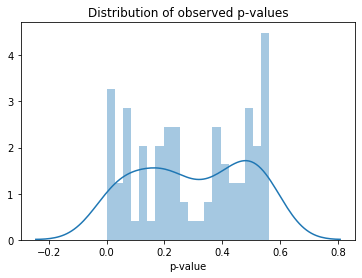

In [11]:
sns.distplot(all_pvalues.iloc[:,0].astype('float'),20)
plt.title('Distribution of observed p-values');

## Write final results to file

In [12]:
# Select significant variables
signif = all_pvalues.loc[all_pvalues.iloc[:,0]<0.05,:]
print(signif.shape[0],"significant candidates were identified")

11 significant candidates were identified


In [13]:
# write to table
signif.to_csv("../Table2/01.candidates_leaf_volatiles_vs_whiteflies.tsv",sep="\t")

## Plots of feature importance averages and standard deviations
These plots show the Random Forest feature importance average and standard deviation for each significant metabolic candidates. Significant metabolic candidates should have their average feature importance different from the distribution of the random feature importances (estimated by the permutations).

In addition, the feature importance standard deviation should not be too important (e.g. relative standard deviation < 50%) as it might impairs its generability to distinguish its importance to distinguish between "toxic" from "non-toxic" genotypes.

Average and standard deviation for each feature are estimate from 5 independent Random Forest runs.

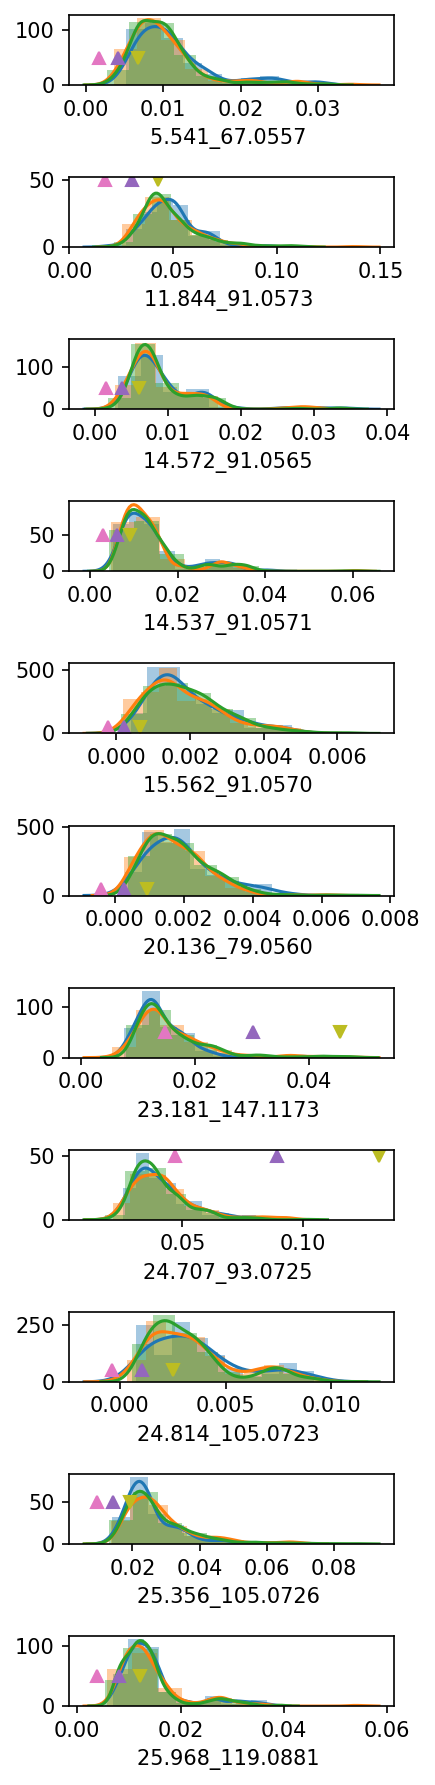

In [14]:
nrplots = len(signif.index.values)
fig = plt.figure(figsize=([3,12]),dpi=150)
ax = fig.subplots(nrows=nrplots,ncols=1)

#yerr = pd.concat([mean_varimportance-2*pooled_std, mean_varimportance,mean_varimportance+2*pooled_std],axis=1)

for i in range(nrplots):                
    plt.subplot(ax[i])
    sns.distplot(feature_importance_perm.loc[signif.index.values[i],:],bins=10,ax=ax[i])
    sns.distplot(feature_importance_perm_250.loc[signif.index.values[i],:],bins=10,ax=ax[i])
    sns.distplot(feature_importance_perm_500.loc[signif.index.values[i],:],bins=10,ax=ax[i])
    plt.plot(yerr.loc[signif.index.values[i],1],0,yerr.loc[signif.index.values[i],1],50,'^')
    plt.plot(yerr.loc[signif.index.values[i],0],0,yerr.loc[signif.index.values[i],0],50,'^')
    plt.plot(yerr.loc[signif.index.values[i],2],0,yerr.loc[signif.index.values[i],2],50,'v')

    
plt.tight_layout()

# Plots (heatmap and sum by class)

## Heatmap
To display a heatmap that shows the rows of the non-toxic genotypes followed by the rows of the toxic genotypes.

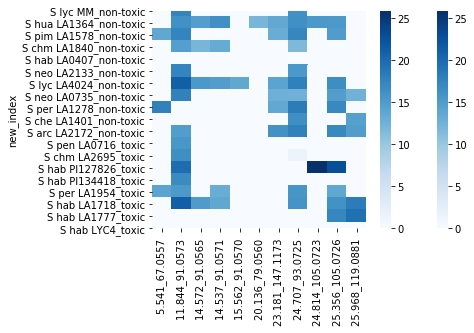

In [113]:
# drops the thrips columns
df_wf = df.drop("thrips",axis=1) 

heatmap_plot = plot_candidate_heatmap(
    df=df_wf,
    class_col="wf",
    significant=signif.index.values,
    log=True
)

# plot
plot_candidate_heatmap(
    df=df_wf,
    class_col="wf",
    significant=signif.index.values,
    log=True
)

## Make plots for each candidate summing over the class

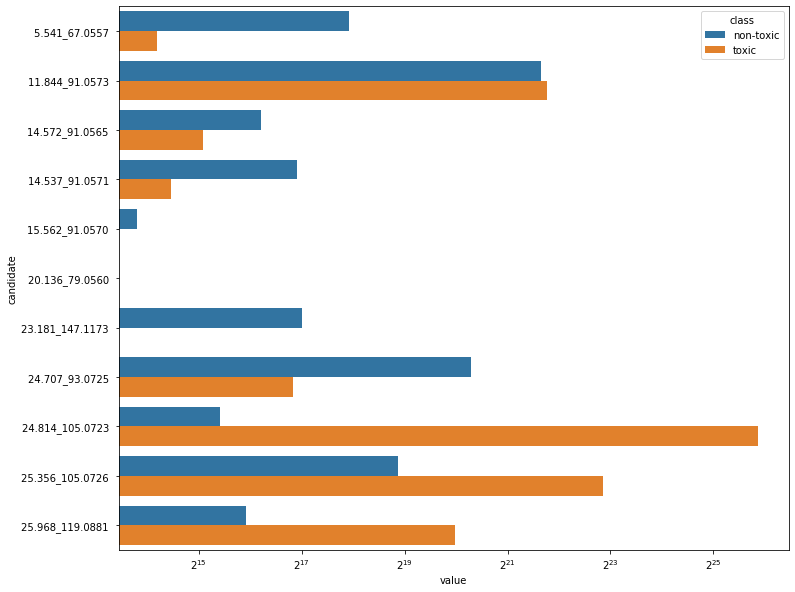

In [16]:
plot_candidate_sum_by_class(
    df = df_wf,
    class_col = "wf",
    significant=signif.index.values
)

# Comparison with Sacha's candidates

In [17]:
import pandas as pd
sacha = pd.read_csv("Sacha_RF_candidates_leaf_volatiles_vs_whiteflies.tsv",sep="\t",header=0)
sacha

,feature,p-value mwu_dataset,p-value p_pnorm,mda_mean
0,24.707_93.0725,0.007278,0.000892,0.024087
1,25.641_119.0875,0.037540,0.064500,0.001763
2,23.181_147.1173,0.018680,0.074000,0.005475
3,22.444_161.1317,0.035890,0.188000,0.007684
4,26.803_111.0836,0.037780,0.230000,0.001942
5,13.396_91.0579,0.031060,0.456000,0.000298


In [95]:
my_candidates = pd.read_csv("../Table2/01.candidates_leaf_volatiles_vs_whiteflies.tsv",sep="\t",header=0)
old_cols = my_candidates.columns.tolist()
new_cols = old_cols
new_cols[0]="feature"
my_candidates.columns = new_cols
my_candidates = my_candidates.sort_values(["p-value","sd"]).loc[my_candidates["p-value"] < 0.01]
my_candidates

,feature,p-value,average,sd,rsd
4,15.562_91.0570,0.0,0.000205,0.000216,1.051981
5,20.136_79.0560,0.0,0.000270,0.000333,1.234999
0,5.541_67.0557,0.0,0.004202,0.001202,0.286163
7,24.707_93.0725,0.0,0.089331,0.021197,0.237287


In [112]:
df_filt = df.loc[:,my_candidates["feature"]]

# Exporting figures

In [78]:
from plotnine.data import mtcars
from plotnine import ggplot, aes, geom_point, stat_smooth, facet_wrap, geom_bar, coord_flip
from plotnine import scale_x_continuous, scale_y_continuous, ylim

In [100]:
classes = list(set(df_wf.loc[:,"wf"].tolist()))

# add the class column as the last column
df_filt["wf"] = df_wf["wf"]

# sum over each category (ignoring the last column that contains the class info)

classA= classes[0]
classB = classes[1]
classA_sum = df_filt.iloc[:,:-1][df_filt["wf"] == classA].sum() 
classB_sum = df_filt.iloc[:,:-1][df_filt["wf"] == classB].sum()

# prepare a dataframe for plotting
sumByClass = pd.DataFrame({classA:classA_sum, classB:classB_sum})
sumByClass = sumByClass.reset_index()
sumByClass.columns.values[0]="candidate"
sumByClass.head()

,candidate,non-toxic,toxic
0,15.562_91.0570,1.429277e+04,0.000000
1,20.136_79.0560,4.238272e+03,0.000000
2,5.541_67.0557,2.471935e+05,18698.825960
3,24.707_93.0725,1.287497e+06,116437.014812


In [101]:
sumByClass_melted = pd.melt(sumByClass, id_vars=['candidate'], value_vars=['non-toxic', 'toxic'])
sumByClass_melted

,candidate,variable,value
0,15.562_91.0570,non-toxic,1.429277e+04
1,20.136_79.0560,non-toxic,4.238272e+03
2,5.541_67.0557,non-toxic,2.471935e+05
3,24.707_93.0725,non-toxic,1.287497e+06
4,15.562_91.0570,toxic,0.000000e+00
5,20.136_79.0560,toxic,0.000000e+00
6,5.541_67.0557,toxic,1.869883e+04
7,24.707_93.0725,toxic,1.164370e+05


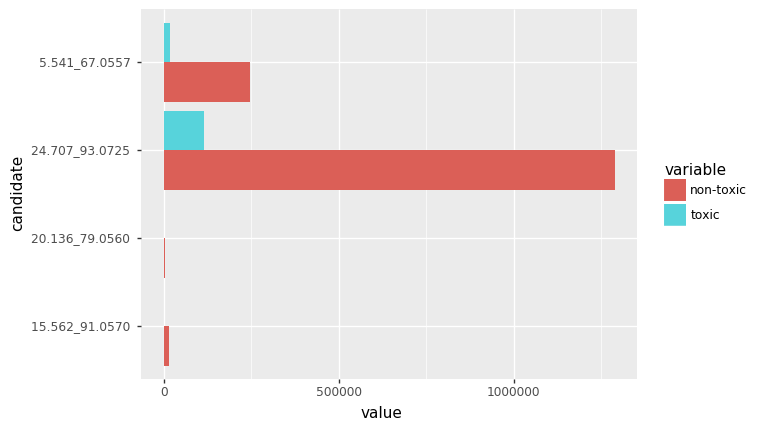

<ggplot: (7561651869)>

In [110]:
p  = (ggplot(
    sumByClass_melted.replace(0,1e-10),
    aes(x="candidate",y='value',fill="variable")
)
+ geom_bar(stat="identity",position="dodge")) + coord_flip() 

p

In [119]:
from plotnine import ggsave
ggsave(filename="Figure5A.pdf",plot=p,width=5,height=7)

/anaconda3/envs/plotnine/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 5 x 7 in image.
  from_inches(height, units), units), PlotnineWarning)
/anaconda3/envs/plotnine/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: Figure5A.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)
